<div style>
   <h1>Projeto de Parceria</h1>
   <b> por <a href="https://www.linkedin.com/in/lucas-zulo/">Lucas Zulo</a> </b>
</div>

---

## Sobre o Projeto

Com o intúito de enfrentar a queda de clientes de uma empresa que oferece um determinado produto ou serviço, este projeto visa usar técnicas de aprendizado de máquina (machine learning) para criar um modelo preditivo do qual pretende identificar clientes que possam vir a se tornar churn.


Churn é uma métrica que indica o número de clientes que cancelaram o contrato ou pararam de comprar um produto em um determinado período de tempo. Por exemplo, clientes que cancelaram o contrato de serviço ou não renovaram após o vencimento são considerados clientes em churn.

<div style>
   Os dados utilizados neste projeto foram fornecidos na plataforma Kaggle e podem ser acessados através deste link: <a href="https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset/data">Kaggle: Customer Churn Dataset</a>
</div>

## Estrutura dos Dados
Os datasets (treinamento e teste) possuem as seguintes colunas:

* CustomerID – Identificação do cliente
* Age – Idade do cliente
* Gender – Gênero do cliente (Male/Female)
* Tenure – Tempo de permanência do cliente com a empresa
* Usage Frequency – Frequência de uso do serviço
* Support Calls – Número de chamadas ao suporte
* Payment Delay – Atraso nos pagamentos
* Subscription Type – Tipo de assinatura (Basic, Standard, Premium)
* Contract Length – Duração do contrato (Monthly, Quarterly, Annual)
* Total Spend – Total gasto pelo cliente
* Last Interaction – Última interação com a empresa
* Churn – Variável Alvo (1 para clientes que cancelaram, 0 para clientes que permaneceram)

In [1]:
# Comandos de instalação
!pip install optuna
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.4 MB/s eta 0:00:00


In [2]:
# Imports da biblioteca padrão
from warnings import filterwarnings
filterwarnings('ignore')

# Imports de bibliotecas de terceiros
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Imports do scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import set_config
set_config(transform_output="pandas")

# Imports de outros pacotes de terceiros
import category_encoders

# Imports do Optuna
import optuna
import optuna.logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [26]:
# Lendo os datasets
treino_df = pd.read_csv('customer_churn_dataset-training-master.csv')
teste_df = pd.read_csv('customer_churn_dataset-testing-master.csv')

## Análise Exploratória de Dados (EDA)

In [27]:
treino_df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [28]:
treino_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [29]:
treino_df.describe(include='all')

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832,440832.000000,440832.000000,440832.000000,440832.000000,440832,440832,440832.000000,440832.000000,440832.000000
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3,3,NaN,NaN,NaN
top,NaN,NaN,Male,NaN,NaN,NaN,NaN,Standard,Annual,NaN,NaN,NaN
freq,NaN,NaN,250252,NaN,NaN,NaN,NaN,149128,177198,NaN,NaN,NaN
mean,225398.667955,39.373153,NaN,31.256336,15.807494,3.604437,12.965722,NaN,NaN,631.616223,14.480868,0.567107
std,129531.918550,12.442369,NaN,17.255727,8.586242,3.070218,8.258063,NaN,NaN,240.803001,8.596208,0.495477
min,2.000000,18.000000,NaN,1.000000,1.000000,0.000000,0.000000,NaN,NaN,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,NaN,16.000000,9.000000,1.000000,6.000000,NaN,NaN,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,NaN,32.000000,16.000000,3.000000,12.000000,NaN,NaN,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,NaN,46.000000,23.000000,6.000000,19.000000,NaN,NaN,830.000000,22.000000,1.000000


In [30]:
# Verificando se há valores nulos
print(treino_df.isna().sum())

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64


In [31]:
# Verificando se há duplicatas
treino_df.duplicated().sum()

0

In [9]:
# Verificando se cada cliente possui apenas uma linha de dados.
print(treino_df['CustomerID'].value_counts().head(10))

CustomerID
2.0         1
301011.0    1
301009.0    1
301008.0    1
301007.0    1
301006.0    1
301005.0    1
301004.0    1
301003.0    1
301002.0    1
Name: count, dtype: int64


> Já que a coluna CustomersID é um identificador único para cada cliente e não tem relação direta com o comportamento do mesmo, iremos remove-la. Aproveitaremos para remover todos os valores nulos.

In [32]:
# Removendo a coluna CustomersID e valores nulos
treino = treino_df.drop(columns=['CustomerID']).copy()
treino = treino.dropna().copy()
teste = teste_df.drop(columns=['CustomerID']).copy()
teste = teste.dropna().copy()

In [33]:
# Separando as colunas categóricas e numéricas
col_categoricas = treino.select_dtypes(include='object').columns.to_list()
col_numericas = treino.select_dtypes(include='number').columns.to_list()

In [34]:
# checking for unique values in categorical columns
for col in col_categoricas:
    print(f'{col}')
    print(f'Únicas: {treino[col].nunique()}')
    print(f'Top 10 valores únicos: {train[col].unique()[:10]}')
    print("="*15)

Gender
Únicas: 2
Top 10 valores únicos: ['Female' 'Male']
Subscription Type
Únicas: 3
Top 10 valores únicos: ['Basic' 'Standard' 'Premium']
Contract Length
Únicas: 3
Top 10 valores únicos: ['Monthly' 'Annual' 'Quarterly']


> Agora precisavos ver se os dados da variável alvo não estão desbalanceados.

In [35]:
# Verificando a proporção da variável alvo do dataset. Quantos clientes cancelaram (1) e quantos permaneceram (0).
treino['Churn'].value_counts(normalize=True)

,proportion
Churn,
1.0,0.567107
0.0,0.432893


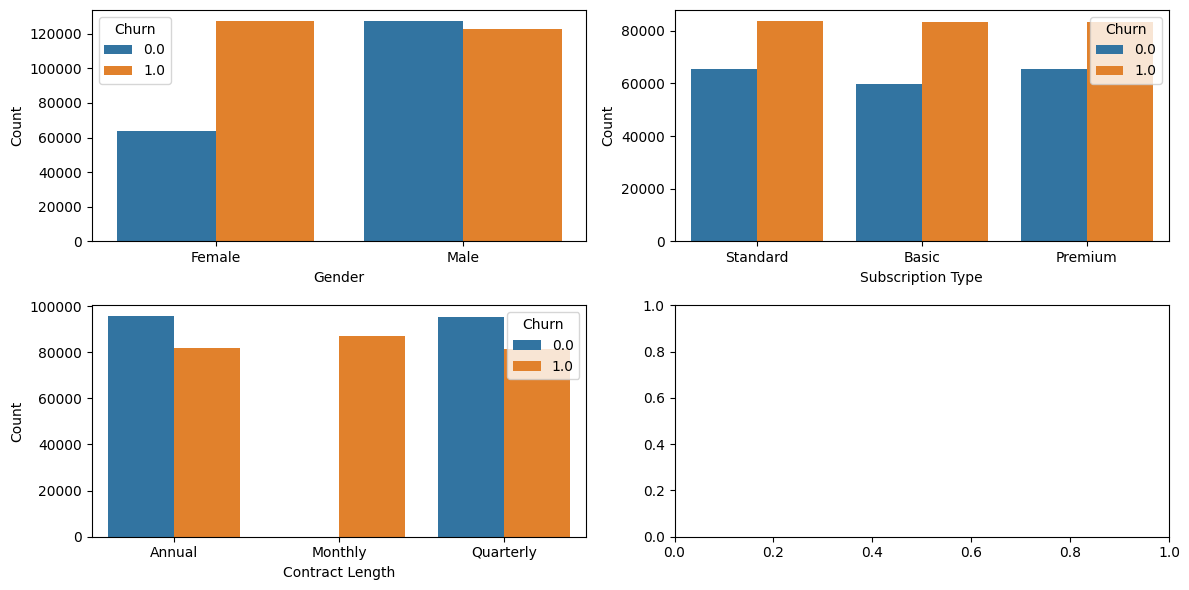

In [36]:
# Plotando variáveis ​​categóricas em relação à variável alvo
fig, axes = plt.subplots(len(col_categoricas)//2+len(col_categoricas)%2, 2, figsize=(12, 6 * (len(col_categoricas)//2)))

for i, col in enumerate(col_categoricas):
    sns.countplot(x=col, data=treino, hue='Churn', ax=axes[i//2, i%2])
    axes[i//2, i%2].set_xlabel(col)
    axes[i//2, i%2].set_ylabel('Count')
    axes[i//2, i%2].legend(title='Churn')

plt.tight_layout()
plt.show()



> Parece que há um desvio significativo no dataset. Vamos mesclar o conjunto de dados para remover o desvio e executar a divisão no conjunto de dados mesclado.

## Modelagem

In [39]:
# Criando os conjuntos de dados de treino e teste a partir dos dados mesclados.
dados_brutos = pd.concat([treino, teste], axis=0, ignore_index=True)
treino, teste = train_test_split(dados_brutos, test_size=0.2, random_state=42, stratify=dados_brutos['Churn'])

# Separando as variáveis X e Y
xtreino = treino.drop(columns=['Churn']).copy()
ytreino = treino[['Churn']].copy()
xteste = teste.drop(columns=['Churn']).copy()
yteste = teste[['Churn']].copy()

# Dividindo os dados
xtreino, xval, ytreino, yval = train_test_split(xtreino, ytreino, test_size=0.3, random_state=42, stratify=ytreino)

In [40]:
# Codificando as variáveis categóricas
codificador = category_encoders.TargetEncoder().fit(xtreino, ytreino)
xtreino = codificador.transform(xtreino)
xteste = codificador.transform(xteste)
xval = codificador.transform(xval)

In [41]:
# Escalonando os dados
escalonador = StandardScaler().fit(xtreino)
xtreino = escalonador.transform(xtreino)
xteste = escalonador.transform(xteste)
xval = escalonador.transform(xval)

In [42]:
# Visualizando estatísticas dos dados após codificação e escalonamento
pd.DataFrame(xtreino).describe()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction
count,2.829140e+05,2.829140e+05,2.829140e+05,2.829140e+05,2.829140e+05,2.829140e+05,2.829140e+05,2.829140e+05,2.829140e+05,2.829140e+05
mean,-1.085728e-16,-4.771878e-17,4.073677e-17,-5.108421e-17,-9.945599e-18,3.719554e-17,-5.677782e-16,6.256184e-16,5.531109e-16,1.245711e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.712456e+00,-8.963651e-01,-1.758962e+00,-1.705481e+00,-1.223550e+00,-1.595663e+00,-7.705676e-01,-5.355280e-01,-2.122903e+00,-1.581681e+00
25%,-8.450729e-01,-8.963651e-01,-8.889976e-01,-8.938400e-01,-9.041170e-01,-8.856851e-01,-7.705676e-01,-5.355280e-01,-7.110753e-01,-8.846225e-01
50%,2.231020e-02,-8.963651e-01,3.896495e-02,3.374927e-02,-2.652515e-01,-5.737802e-02,-6.188827e-01,-5.145141e-01,1.172511e-01,-7.138805e-02
75%,7.319873e-01,1.115617e+00,8.509322e-01,8.453899e-01,6.930467e-01,7.709291e-01,1.434370e+00,-5.145141e-01,8.313256e-01,8.580228e-01
max,1.993635e+00,1.115617e+00,1.662899e+00,1.657031e+00,1.970778e+00,1.954225e+00,1.434370e+00,1.904707e+00,1.549480e+00,1.787434e+00


> Vamos usar o modelo de Árvore de Decisão, pois, é um modelo simples que pode servir como ponto de partida.

#### Árvore de Decisão

In [45]:
# Criando o modelo de Árvore de Decisão
modelo_ad = DecisionTreeClassifier(random_state=42)

# Treinando o modelo com os dados de treino
modelo_ad.fit(xtreino, ytreino)

# Fazendo previsões
ytreino_pred = modelo_ad.predict(xtreino)
yval_pred = modelo_ad.predict(xval)
yteste_pred = modelo_ad.predict(xteste)

In [47]:
# Avaliação do modelo
print("Acurácia no Treino:", accuracy_score(ytreino, ytreino_pred))
print("Acurácia na Validação:", accuracy_score(yval, yval_pred))
print("Acurácia no Teste:", accuracy_score(yteste, yteste_pred))

# Matriz de confusão
print("\nMatriz de Confusão (Validação):\n", confusion_matrix(yval, yval_pred))

# Relatório de Classificação
print("\nRelatório de Classificação (Validação):\n", classification_report(yval, yval_pred))

Acurácia no Treino: 1.0
Acurácia na Validação: 0.883439175257732
Acurácia no Teste: 0.8837216207121791

Matriz de Confusão (Validação):
 [[47649  6283]
 [ 7850 59468]]

Relatório de Classificação (Validação):
               precision    recall  f1-score   support

         0.0       0.86      0.88      0.87     53932
         1.0       0.90      0.88      0.89     67318

    accuracy                           0.88    121250
   macro avg       0.88      0.88      0.88    121250
weighted avg       0.88      0.88      0.88    121250



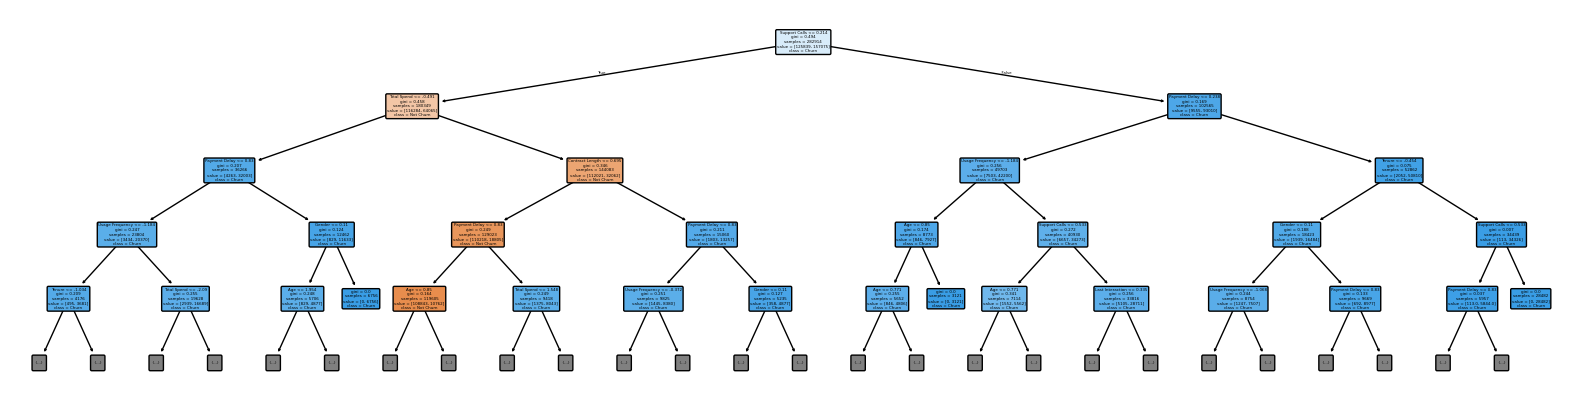

In [49]:
# Plotando a árvore treinada
plt.figure(figsize=(20, 5))
plot_tree(modelo_ad, feature_names=xtreino.columns, class_names=['Not Churn', 'Churn'], filled=True, rounded=True, max_depth=4)
plt.show()

> Vamos analisar a correlação entre as features e a variável alvo.

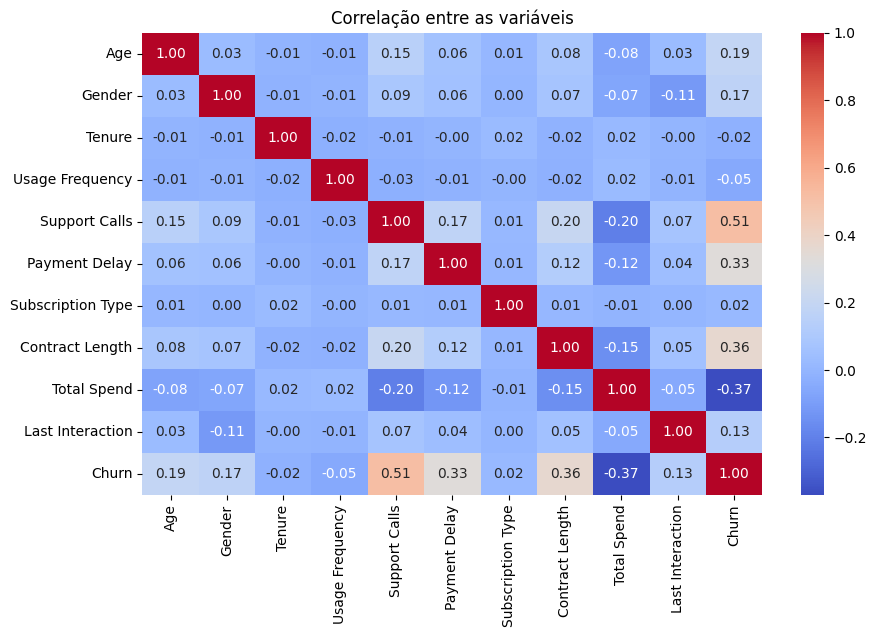

In [50]:
# Criando um DataFrame temporário com os dados já transformados
temp_df = pd.DataFrame(xtreino, columns=xtreino.columns)
temp_df['Churn'] = ytreino.values  # Adicionando a variável-alvo

# Matriz de correlação
plt.figure(figsize=(10, 6))
sns.heatmap(temp_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlação entre as variáveis")
plt.show()

> Como podemos ver, com 88% de acurácia, o modelo mostrou resultados razoáveis, mas podemos melhora-lo. O principal problema é o overfitting no treino, que pode ser resolvido com ajustes de hiperparâmetros. Devemos então, explorar outro modelo para obter uma acurácia mais precisa. Vamos refina-lo com o modelo de Random Forest.

### Random Forest

In [51]:
# Criando o modelo de Random Forest
modelo_ad = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Treinando o modelo com os dados de treino
modelo_ad.fit(xtreino, ytreino)

# Fazendo previsões
ytreino_pred_rf = modelo_ad.predict(xtreino)
yval_pred_rf = modelo_ad.predict(xval)
yteste_pred_rf = modelo_ad.predict(xteste)

> Agora, vamos avaliar o desempenho do modelo Random Forest em relação com a Árvore de Decisão, para verificar se é um modelo mais preciso.

In [52]:
# Avaliando no conjunto de validação
print("Acurácia na validação:", accuracy_score(yval, yval_pred_rf))
print("Relatório de classificação:\n", classification_report(yval, yval_pred_rf))
print("Matriz de confusão:\n", confusion_matrix(yval, yval_pred_rf))

# Avaliando no conjunto de teste
print("Acurácia no teste:", accuracy_score(yteste, yteste_pred_rf))
print("Relatório de classificação no teste:\n", classification_report(yteste, yteste_pred_rf))
print("Matriz de confusão no teste:\n", confusion_matrix(yteste, yteste_pred_rf))

Acurácia na validação: 0.9367752577319588
Relatório de classificação:
               precision    recall  f1-score   support

         0.0       1.00      0.86      0.92     53932
         1.0       0.90      1.00      0.95     67318

    accuracy                           0.94    121250
   macro avg       0.95      0.93      0.93    121250
weighted avg       0.94      0.94      0.94    121250

Matriz de confusão:
 [[46331  7601]
 [   65 67253]]
Acurácia no teste: 0.9371845371231765
Relatório de classificação no teste:
               precision    recall  f1-score   support

         0.0       1.00      0.86      0.92     44943
         1.0       0.90      1.00      0.95     56099

    accuracy                           0.94    101042
   macro avg       0.95      0.93      0.94    101042
weighted avg       0.94      0.94      0.94    101042

Matriz de confusão no teste:
 [[38661  6282]
 [   65 56034]]


Testando o modelo no conjunto de teste.

In [53]:
# Acurácia no conjunto de teste
teste_acuracia = accuracy_score(yteste, yteste_pred_rf)
print("Acurácia no conjunto de teste:", teste_acuracia)

# Relatório de classificação
print("\nRelatório de Classificação no Teste:")
print(classification_report(yteste, yteste_pred_rf))

# Matriz de Confusão
print("\nMatriz de Confusão no Teste:")
print(confusion_matrix(yteste, yteste_pred_rf))

Acurácia no conjunto de teste: 0.9371845371231765

Relatório de Classificação no Teste:
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92     44943
         1.0       0.90      1.00      0.95     56099

    accuracy                           0.94    101042
   macro avg       0.95      0.93      0.94    101042
weighted avg       0.94      0.94      0.94    101042


Matriz de Confusão no Teste:
[[38661  6282]
 [   65 56034]]


## Conclusão e Interpretação dos Resultados

O modelo apresentou uma acurácia de aproximadamente **93,7%** no conjunto de teste. Um salto em relação aos 88% com a Árvore de Decisão, que obteve uma acurácia de treino de 1.0, indicando overfitting. Isso demonstra que o modelo final escolhido foi otimizado com sucesso, mantendo alta generalização. Essa taxa é muito boa, considerando o desafio de previsão de churn (cliente que cancela sua assinatura).

Os resultados demonstram que o modelo Random Forest está muito bem ajustado para fazer sua previsão:

* **Excelente detecção de churn:** Com um recall de quase 100% para clientes que cancelaram, o modelo é altamente eficaz para identificar os clientes em risco.
* **Alto nível de confiança nas previsões:** A precisão de 1.00 para clientes que permanecem e 0.90 para os churners indicam que a maioria das previsões é correta.
* **Base sólida para estratégias de retenção:** Esses resultados fornecem uma excelente base para que ações direcionadas de retenção sejam implementadas, minimizando perdas e otimizando os recursos.

Por fim, o modelo atende bem aos objetivos do projeto de churn, permitindo identificar com alta confiabilidade os clientes que cancelaram o serviço e possibilitando uma ação preventiva eficaz.